In [1]:
# 导入包
import os
import cv2 
import math
import random
import numpy as np
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dense, Flatten

In [2]:
actions = np.array(['Afraid', 'Excited', 'Annoyed', 'Bored' ,'Happy','Angry'])

In [3]:
indices_to_keep = [0, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]

In [4]:
label_map = {label:num for num, label in enumerate(actions)}

In [5]:
label_map

{'Afraid': 0, 'Excited': 1, 'Annoyed': 2, 'Bored': 3, 'Happy': 4, 'Angry': 5}

In [6]:
# 提取距离速度加速度方法
def calc_baseline(action_list):
    left_shoulder_right_shoulder_distance_list = []
    left_shoulder_left_elbow_distance_list = []
    left_elbow_left_wrist_distance_list = []
    left_hip_left_knee_distance_list = []
    std_list = []
    
    for i in range(len(action_list)):
        left_shoulder_right_shoulder_distance = math.hypot(action_list[i][11].x-action_list[i][12].x, action_list[i][11].y-action_list[i][12].y)
        left_shoulder_left_elbow_distance = math.hypot(action_list[i][11].x-action_list[i][13].x, action_list[i][11].y-action_list[i][13].y)
        left_elbow_left_wrist_distance = math.hypot(action_list[i][13].x-action_list[i][15].x, action_list[i][13].y-action_list[i][15].y)
        left_hip_left_knee_distance = math.hypot(action_list[i][23].x-action_list[i][25].x, action_list[i][23].y-action_list[i][25].y)
    
        left_shoulder_right_shoulder_distance_list.append(left_shoulder_right_shoulder_distance)
        left_shoulder_left_elbow_distance_list.append(left_shoulder_left_elbow_distance)
        left_elbow_left_wrist_distance_list.append(left_elbow_left_wrist_distance)
        left_hip_left_knee_distance_list.append(left_hip_left_knee_distance)
        
    std0 = np.array(left_shoulder_right_shoulder_distance_list).std() 
    std1 = np.array(left_shoulder_left_elbow_distance_list).std()
    std2 = np.array(left_elbow_left_wrist_distance_list).std()
    std3 = np.array(left_hip_left_knee_distance_list).std()
    std_list = [std0, std1, std2, std3]
    std_min = min(std_list)
    std_index = std_list.index(std_min)
    if std_index == 0:
        norm_list = left_shoulder_right_shoulder_distance_list
    elif std_index == 1:
        norm_list = left_shoulder_left_elbow_distance_list
    elif std_index == 2:
        norm_list = left_elbow_left_wrist_distance_list
    elif std_index == 3:
        norm_list = left_hip_left_knee_distance_list
    return norm_list, std_index


def calc_all(action_list):
    norm_list, std_num = calc_baseline(action_list)

    left_ankle_left_hip_distance_list = []
    right_ankle_right_hip_distance_list = []
    left_wrist_left_shoulder_distance_list = []
    right_wrist_right_shoulder_distance_list = []
    left_wrist_nose_distance_list = []
    right_wrist_nose_distance_list = []
    left_wrist_left_hip_distance_list = []
    right_wrist_right_hip_distance_list = []
    
    for i in range(len(action_list)):
        left_ankle_left_hip_distance        = math.hypot(action_list[i][27].x-action_list[i][23].x, action_list[i][27].y-action_list[i][23].y)
        right_ankle_right_hip_distance      = math.hypot(action_list[i][28].x-action_list[i][24].x, action_list[i][28].y-action_list[i][24].y)
        left_wrist_left_shoulder_distance   = math.hypot(action_list[i][15].x-action_list[i][11].x, action_list[i][15].y-action_list[i][11].y)
        right_wrist_right_shoulder_distance = math.hypot(action_list[i][16].x-action_list[i][12].x, action_list[i][16].y-action_list[i][12].y)
        left_wrist_nose_distance            = math.hypot(action_list[i][15].x-action_list[i][0].x, action_list[i][15].y-action_list[i][0].y)
        right_wrist_nose_distance           = math.hypot(action_list[i][16].x-action_list[i][0].x, action_list[i][16].y-action_list[i][0].y)
        left_wrist_left_hip_distance        = math.hypot(action_list[i][15].x-action_list[i][23].x, action_list[i][15].y-action_list[i][23].y)
        right_wrist_right_hip_distance      = math.hypot(action_list[i][16].x-action_list[i][24].x, action_list[i][16].y-action_list[i][24].y)

        left_ankle_left_hip_distance_list.append(left_ankle_left_hip_distance)
        right_ankle_right_hip_distance_list.append(right_ankle_right_hip_distance)
        left_wrist_left_shoulder_distance_list.append(left_wrist_left_shoulder_distance)
        right_wrist_right_shoulder_distance_list.append(right_wrist_right_shoulder_distance)
        left_wrist_nose_distance_list.append(left_wrist_nose_distance)
        right_wrist_nose_distance_list.append(right_wrist_nose_distance)
        left_wrist_left_hip_distance_list.append(left_wrist_left_hip_distance)
        right_wrist_right_hip_distance_list.append(right_wrist_right_hip_distance)
        
    # 计算速度
    left_ankle_velocity_list = []
    right_ankle_velocity_list = []
    left_hip_velocity_list = []
    right_hip_velocity_list = []
    left_wrist_velocity_list = []
    right_wrist_velocity_list = []

    for i in range(len(action_list)-1):
        left_ankle_velocity     = math.hypot(action_list[i+1][27].x-action_list[i][27].x, action_list[i+1][27].y-action_list[i][27].y)/cut_frame
        right_ankle_velocity    = math.hypot(action_list[i+1][28].x-action_list[i][28].x, action_list[i+1][28].y-action_list[i][28].y)/cut_frame
        left_hip_velocity       = math.hypot(action_list[i+1][23].x-action_list[i][23].x, action_list[i+1][23].y-action_list[i][23].y)/cut_frame
        right_hip_velocity      = math.hypot(action_list[i+1][24].x-action_list[i][24].x, action_list[i+1][24].y-action_list[i][24].y)/cut_frame
        left_wrist_velocity     = math.hypot(action_list[i+1][15].x-action_list[i][15].x, action_list[i+1][15].y-action_list[i][15].y)/cut_frame
        right_wrist_velocity    = math.hypot(action_list[i+1][16].x-action_list[i][16].x, action_list[i+1][16].y-action_list[i][16].y)/cut_frame

        left_ankle_velocity_list.append(left_ankle_velocity)
        right_ankle_velocity_list.append(right_ankle_velocity)
        left_hip_velocity_list.append(left_hip_velocity)
        right_hip_velocity_list.append(right_hip_velocity)
        left_wrist_velocity_list.append(left_wrist_velocity)
        right_wrist_velocity_list.append(right_wrist_velocity)
        
    # 计算加速度
    left_ankle_acceleration_list = []
    right_ankle_acceleration_list = []
    left_hip_acceleration_list = []
    right_hip_acceleration_list = []
    left_wrist_acceleration_list = []
    right_wrist_acceleration_list = []

    for i in range(len(action_list)-2):
        left_ankle_acceleration = (left_ankle_velocity_list[i+1]-left_ankle_velocity_list[i])/cut_frame
        right_ankle_acceleration= (right_ankle_velocity_list[i+1]-right_ankle_velocity_list[i])/cut_frame
        left_hip_acceleration   = (left_hip_velocity_list[i+1]-left_hip_velocity_list[i])/cut_frame 
        right_hip_acceleration  = (right_hip_velocity_list[i+1]-right_hip_velocity_list[i])/cut_frame 
        left_wrist_acceleration = (left_wrist_velocity_list[i+1]-left_wrist_velocity_list[i])/cut_frame  
        right_wrist_acceleration= (right_wrist_velocity_list[i+1]-right_wrist_velocity_list[i])/cut_frame

        left_ankle_acceleration_list.append(left_ankle_acceleration)
        right_ankle_acceleration_list.append(right_ankle_acceleration)
        left_hip_acceleration_list.append(left_hip_acceleration)
        right_hip_acceleration_list.append(right_hip_acceleration)
        left_wrist_acceleration_list.append(left_wrist_acceleration)
        right_wrist_acceleration_list.append(right_wrist_acceleration)
    
    # 计算DataFrame
    LMA_measurement = { 
        
                    'norm_d': pd.Series(data = norm_list),
    
                    #Body
                   'l_ankle_l_hip_d': pd.Series(data = left_ankle_left_hip_distance_list),
                   'r_ankle_r_hip_d': pd.Series(data = right_ankle_right_hip_distance_list),
                   'l_wrist_nose_d': pd.Series(data = left_wrist_nose_distance_list),
                   'r_wrist_nose_d': pd.Series(data = right_wrist_nose_distance_list),
                   'l_wrist_l_hip_d': pd.Series(data = left_wrist_left_hip_distance_list),
                   'r_wrist_r_hip_d': pd.Series(data = right_wrist_right_hip_distance_list),
                    #Effort velocity
                   'l_ankle_v': pd.Series(data = left_ankle_velocity_list),
                   'r_ankle_v': pd.Series(data = right_ankle_velocity_list),
                   'l_hip_v': pd.Series(data = left_hip_velocity_list),
                   'r_hip_v': pd.Series(data = right_hip_velocity_list),
                   'l_wrist_v': pd.Series(data = left_wrist_velocity_list),
                   'r_wrist_v': pd.Series(data = right_wrist_velocity_list),
                    #Effort acceleration
                   'l_ankle_a': pd.Series(data = left_ankle_acceleration_list),
                   'r_ankle_a': pd.Series(data = right_ankle_acceleration_list),
                   'l_hip_a': pd.Series(data = left_hip_acceleration_list),
                   'r_hip_a': pd.Series(data = right_hip_acceleration_list),
                   'l_wrist_a': pd.Series(data = left_wrist_acceleration_list),
                   'r_wrist_a': pd.Series(data = right_wrist_acceleration_list),   
                  }
    # 处理DataFrame
    LMA_measurement_df = pd.DataFrame(LMA_measurement)

    # 根据std位置不同，选择不同norm数据
    if std_num == 0:
        norm = LMA_measurement_df['norm_d']/40
    elif std_num == 1:
        norm = LMA_measurement_df['norm_d']/30
    elif std_num == 2:
        norm = LMA_measurement_df['norm_d']/25
    elif std_num == 3:
        norm = LMA_measurement_df['norm_d']/60
    Seven_LMA_measurement_norm_df = LMA_measurement_df.iloc[:, :7].div(norm, axis=0) 
    LMA_measurement_norm_df = pd.concat([Seven_LMA_measurement_norm_df, LMA_measurement_df.iloc[:, 7:]], axis=1)
    LMA_measurement_norm_df = LMA_measurement_norm_df.dropna()
    LMA_measurement_norm_df = LMA_measurement_norm_df.drop(columns = ['norm_d']) 
    return LMA_measurement_norm_df

# 归一化处理函数
def calc_norm(action_df):
    normalized = np.arctan(MinMaxScaler().fit_transform(action_df.T).T)
    norm_action_df = pd.DataFrame(normalized, columns=action_df.columns)
    return norm_action_df

In [7]:
cut_frame = 10

static_xy_list = []
lma_list = []
array_history = []
label_list = []

train_path =  os.path.join(r"D:\anaconda\git\DANCE\BC_Dance_Clip_Change1\train")
for sub_folder in actions:
    print(sub_folder)
    for category_folder in os.listdir(train_path +'\\'+ sub_folder):
        print(category_folder)
        current_frame = 0
        for file in os.listdir(train_path + '\\'+ sub_folder + '\\' + category_folder):
            file_path = train_path + '\\'+ sub_folder + '\\' + category_folder + '\\' + file
#             print(file_path)
            res = np.load(file_path, allow_pickle=True)
            keypoints_xy_list = []
            # 只提取精简之后关键点
            for k in indices_to_keep:
                keypoint_xy = np.array([res[k].x, res[k].y])
                keypoints_xy_list.append(keypoint_xy)
            static_xy_list.append(np.array(keypoints_xy_list).flatten())
            
            if current_frame % 10 == 0:
                lma_list.append(res)
                
            current_frame = current_frame + 1
            
            if len(lma_list) == 3:
                lma_df = calc_all(lma_list)
                norm_lma_df = calc_norm(lma_df)
                norm_lma_np = norm_lma_df.values
                norm_lma_1np = norm_lma_np.reshape(-1)
                np_static_xy_list = np.array(static_xy_list)
                tem_merge = np.concatenate((np_static_xy_list, np.tile(norm_lma_1np, (np_static_xy_list.shape[0], 1))), axis=1)
                array_history.append(tem_merge)
                
                for i in range(len(np_static_xy_list)):
                    label_list.append(label_map[sub_folder])
                    
                static_xy_list = []
                lma_list = []

# 最终融合后的二维np数组
merge_train = np.vstack(array_history) 

Afraid
folder_1
folder_2
folder_3
folder_4
folder_5
folder_6
folder_7
folder_8
folder_9
Excited
folder_1
folder_2
folder_3
folder_4
folder_5
folder_6
folder_7
folder_8
folder_9
Annoyed
folder_1
folder_2
folder_3
folder_4
folder_5
folder_6
folder_7
folder_8
folder_9
Bored
folder_1
folder_2
folder_3
folder_4
folder_5
folder_6
folder_7
folder_8
folder_9
Happy
folder_1
folder_2
folder_3
folder_4
folder_5
folder_6
folder_7
folder_8
Angry
folder_1
folder_2
folder_3
folder_4
folder_5
folder_6
folder_7
folder_8
folder_9


In [8]:
merge_train.shape

(26553, 44)

In [9]:
len(label_list)

26553

In [10]:
counter = Counter(label_list)
Afraid_num =  counter[0]
Annoyed_num = counter[1]
Bored_num = counter[2]
Excied_num = counter[3]
print(Afraid_num, Annoyed_num,Bored_num, Excied_num)

4509 4509 4509 4509


In [11]:
# 整理训练集
X_train = merge_train
y_train = to_categorical(label_list).astype(int)

In [12]:
cut_frame = 10

static_xy_list = []
lma_list = []
array_history = []
test_label_list = []

test_path =  os.path.join(r"D:\anaconda\git\DANCE\BC_Dance_Clip_Change1\test")
for sub_folder in actions:
    print(sub_folder)
    for category_folder in os.listdir(test_path +'\\'+ sub_folder):
        print(category_folder)
        current_frame = 0
        for file in os.listdir(test_path + '\\'+ sub_folder + '\\' + category_folder):
            file_path = test_path + '\\'+ sub_folder + '\\' + category_folder + '\\' + file
#             print(file_path)
            res = np.load(file_path, allow_pickle=True)
            keypoints_xy_list = []
            for k in indices_to_keep:
                keypoint_xy = np.array([res[k].x, res[k].y])
                keypoints_xy_list.append(keypoint_xy)
            static_xy_list.append(np.array(keypoints_xy_list).flatten())
            
            if current_frame % 10 == 0:
                lma_list.append(res)
                
            current_frame = current_frame + 1
            
            if len(lma_list) == 3:
                lma_df = calc_all(lma_list)
                norm_lma_df = calc_norm(lma_df)
                norm_lma_np = norm_lma_df.values
                norm_lma_1np = norm_lma_np.reshape(-1)
                np_static_xy_list = np.array(static_xy_list)
                tem_merge = np.concatenate((np_static_xy_list, np.tile(norm_lma_1np, (np_static_xy_list.shape[0], 1))), axis=1)
                array_history.append(tem_merge)
                
                for i in range(len(np_static_xy_list)):
                    test_label_list.append(label_map[sub_folder])
                    
                static_xy_list = []
                lma_list = []

# 最终融合后的二维np数组
test_merge_train = np.vstack(array_history)

Afraid
folder_9
Excited
folder_9
Annoyed
folder_9
Bored
folder_9
Happy
folder_9
Angry
folder_9


In [13]:
test_merge_train.shape

(3006, 44)

In [14]:
len(test_label_list)

3006

In [15]:
counter = Counter(test_label_list)
Afraid_num =  counter[0]
Annoyed_num = counter[1]
Bored_num = counter[2]
Excied_num = counter[3]
print(Afraid_num, Annoyed_num,Bored_num, Excied_num)

501 501 501 501


In [16]:
# 整理测试集
X_test = test_merge_train
y_test = to_categorical(test_label_list).astype(int)

In [17]:
train_indices = np.random.permutation(X_train.shape[0])
test_indices =  np.random.permutation(X_test.shape[0])

In [18]:
X_train = X_train[train_indices]
y_train = y_train[train_indices]

X_test = X_test[test_indices]
y_test = y_test[test_indices]

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((26553, 44), (26553, 6), (3006, 44), (3006, 6))

In [20]:
np.random.seed(0)
tf.random.set_seed(0)

In [21]:
from tensorflow.keras.layers import Dropout

# 搭模型进行训练
def train_and_test_model(X_train, y_train, X_test, y_test):
    
    # 搭建模型
    model = Sequential()  
    model.add(Dense(256, activation='relu', input_shape=(44, )))
#    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
#     model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))

#     编译模型 调试参数
#     learning_rate = 0.001
#     batch_size = 32
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
#     编译模型 默认参数
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    # 训练
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Percentage')
    plt.xlabel('Epoch')
    plt.legend(['train','test'])
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train','test'])
    plt.show()
    # 查看模型结构
    model.summary()
    return model

Epoch 1/50


D:\anaconda\envs\SAM1\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


830/830 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - categorical_accuracy: 0.2443 - loss: 1.7120 - val_categorical_accuracy: 0.1727 - val_loss: 1.9207
Epoch 2/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.3962 - loss: 1.4580 - val_categorical_accuracy: 0.1996 - val_loss: 1.8762
Epoch 3/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.4314 - loss: 1.3694 - val_categorical_accuracy: 0.2472 - val_loss: 1.8072
Epoch 4/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.4691 - loss: 1.2879 - val_categorical_accuracy: 0.2372 - val_loss: 1.8546
Epoch 5/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.4952 - loss: 1.2261 - val_categorical_accuracy: 0.2851 - val_loss: 1.7898
Epoch 6/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.5338 - loss: 1.1497 - val_categorical_accuracy: 0.3480 - val_loss: 1.7279
Epoch 7/50
830/830 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.5680 - loss: 1.0796 -

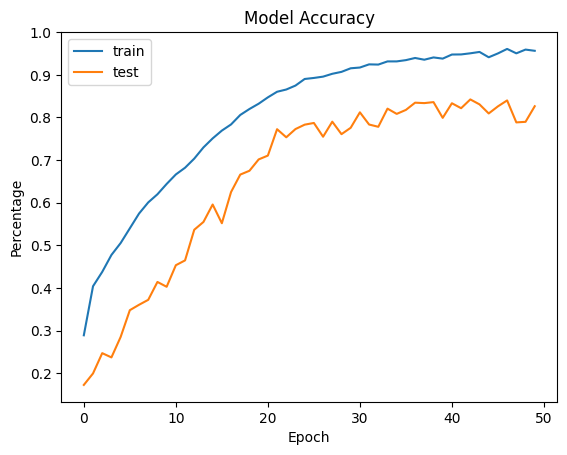

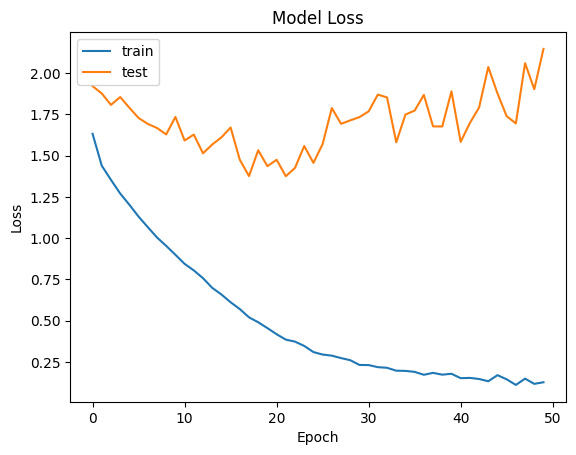

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          11,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │              54 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,412 (650.05 KB)

 Trainable params: 55,470 (216.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 110,942 (433.37 KB)

In [22]:
model = train_and_test_model(X_train, y_train, X_test, y_test)

In [23]:
y_true = np.argmax(y_test, axis=1).tolist()
y_pred_dnn = model.predict(X_test)
y_pred_dnn = np.argmax(y_pred_dnn, axis=1).tolist()
accuracy_score(y_true, y_pred_dnn)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.8263473053892215

Deep Neural Network Classifier:



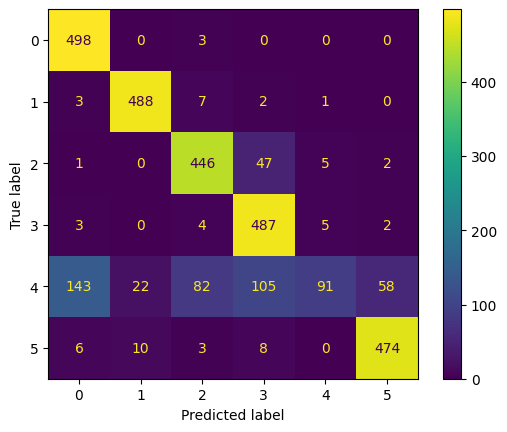

In [24]:
print('Deep Neural Network Classifier:\n')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred_dnn)

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [26]:
print(precision_score(y_true, y_pred_dnn))
print(recall_score(y_true, y_pred_dnn))
print(f1_score(y_true, y_pred_dnn))

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
# 经典机器学习方法结果检查
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

In [ ]:
# 固定随机数种子
seed = 1

In [ ]:
# Random Forest Classifier
forest = RandomForestClassifier(random_state=seed)
forest.fit(X_train,y_train)
y_pred_forest = forest.predict(X_test)
y_true = np.argmax(y_test, axis=1).tolist()
y_pred_forest = np.argmax(y_pred_forest, axis=1).tolist()
accuracy_score(y_true, y_pred_forest)

In [ ]:
print('Random Forest Classifier:\n')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred_forest)

In [ ]:
precision_score(y_true, y_pred_forest)

In [ ]:
recall_score(y_true, y_pred_forest)

In [ ]:
f1_score(y_true, y_pred_forest)

In [ ]:
# logistics regression
linear = LogisticRegression(max_iter=2000, random_state=seed)
y_train_1d = np.argmax(y_train, axis=1)
linear.fit(X_train, y_train_1d)
y_pred_linear = linear.predict(X_test)
accuracy_score(y_true, y_pred_linear)

In [ ]:
print('Linear Classifier:\n')
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_linear)

In [ ]:
precision_score(y_true, y_pred_linear)

In [ ]:
recall_score(y_true, y_pred_linear)

In [ ]:
f1_score(y_true, y_pred_linear)

In [ ]:
# decison tree
tree = DecisionTreeClassifier(random_state=seed)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_true = np.argmax(y_test, axis=1).tolist()
y_pred_tree = np.argmax(y_pred_tree, axis=1).tolist()
accuracy_score(y_true, y_pred_tree)

In [ ]:
print('Decision Tree Classifier:\n')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred_tree)

In [ ]:
precision_score(y_true, y_pred_tree)

In [ ]:
recall_score(y_true, y_pred_tree)

In [ ]:
f1_score(y_true, y_pred_tree)

In [ ]:
# SVM
svm = LinearSVC(max_iter=2500, random_state=seed)
y_train_1d = np.argmax(y_train, axis=1)
svm.fit(X_train, y_train_1d)
y_pred_svm = svm.predict(X_test)
accuracy_score(y_true, y_pred_svm)

In [ ]:
print('SVM Classifier:\n')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred_svm)

In [ ]:
precision_score(y_true, y_pred_svm)

In [ ]:
recall_score(y_true, y_pred_svm)

In [ ]:
f1_score(y_true, y_pred_svm)

In [ ]:
# Naive bayes
bayes = GaussianNB()
y_train_1d = np.argmax(y_train, axis=1)
bayes.fit(X_train, y_train_1d)
y_pred_bayes = bayes.predict(X_test)
accuracy_score(y_true, y_pred_bayes)

In [ ]:
print('Naive Bayes Classifier:\n')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred_bayes)

In [ ]:
precision_score(y_true, y_pred_bayes)

In [ ]:
recall_score(y_true, y_pred_bayes)

In [ ]:
f1_score(y_true, y_pred_bayes)